<a href="https://colab.research.google.com/github/jscherba/CardiacMRIModel/blob/main/cardiacMRImodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **A machine learning approach to reduce cardiac MRI acquisition time**
The script below was written by Jacob Scherba.

### Overall Approach
Using data from the Sunnybrook Cardiac Database, I trained a convolutional neural network to classify cardiac MRI data into one of 4 diagnostic categories. By modeling the physical layer of MRI acquisition as a 2D mask in k-space, I was able to identify a possible pattern of important image information. Using the assumption that this information could be retained while removing some iterations of MRI acquisition, I was able to reduce the modeled MRI acquisition time by 30% without significantly impacting diagnostic accuracy. These data support the investigation of streamlined cardiac MRI acquisition to promote patient comfort and improved utilization of hospital resources.


In [2]:
!pip install pydicom

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import scipy as sp
import shutil
import numpy as np
import pydicom

import time
import sys
import math
import os
import csv

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.decomposition import PCA

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# download data from Sunnybrook database
!wget --content-disposition 'https://www.cardiacatlas.org/share/download.php?id=98&token=kUVtCTMzfjlHwunzFYST7yNGFnlUtV7W&download' -O SCD_IMAGES_01.zip
!wget --content-disposition 'https://www.cardiacatlas.org/share/download.php?id=99&token=2euh4WH03DynHi9Y5elb2HSWJaJIeWER&download' -O SCD_IMAGES_02.zip
!wget --content-disposition 'https://www.cardiacatlas.org/share/download.php?id=100&token=eT37AbXslu1JQp1GSZy2BmmWzWmXDdfx&download' -O SCD_IMAGES_03.zip
!wget --content-disposition 'https://www.cardiacatlas.org/share/download.php?id=101&token=Qn0dY2lHTyTIBF5qNHRkbHdUSnWnS4Yy&download' -O SCD_IMAGES_04.zip
!wget --content-disposition 'https://www.cardiacatlas.org/share/download.php?id=102&token=nYALJl6kS6cj5jgK9R8CKDpgQwZn1pm3&download' -O SCD_IMAGES_05.zip

!wget --content-disposition 'https://www.cardiacatlas.org/share/download.php?id=66&token=Y1D66ieUdbXFlqmZ4icHJheJy44MXUPY&download' -O scd_patientdata.csv

In [3]:
# mount google drive
# just accept the request despite the security concerns, Google has all your data already
from google.colab import drive
drive.mount('/content/drive')

project_data_dir = 'project_data'

os.makedirs(project_data_dir)

Mounted at /content/drive


In [4]:
shutil.unpack_archive('SCD_IMAGES_01.zip', 'project_data/SCD_IMAGES_01', format='zip')
shutil.unpack_archive('SCD_IMAGES_02.zip', 'project_data/SCD_IMAGES_02', format='zip')
shutil.unpack_archive('SCD_IMAGES_03.zip', 'project_data/SCD_IMAGES_03', format='zip')
shutil.unpack_archive('SCD_IMAGES_04.zip', 'project_data/SCD_IMAGES_04', format='zip')
shutil.unpack_archive('SCD_IMAGES_05.zip', 'project_data/SCD_IMAGES_05', format='zip')

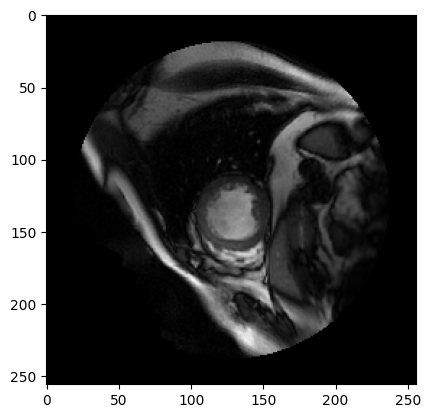

In [8]:
dicom_dir = '/content/project_data/SCD_IMAGES_01/SCD0000101/CINESAX_300'

# Create a list to store the pixel data
pixel_data = []

# Loop through all files in the directory
for filename in os.listdir(dicom_dir):
    file_path = os.path.join(dicom_dir, filename)

    # Read the DICOM file
    ds = pydicom.dcmread(file_path)

    # Extract the pixel data and append it to the list
    pixel_data.append(ds.pixel_array)

# Visualize the first frame
plt.imshow(pixel_data[27], cmap='gray')
plt.show()

In [3]:
patient_data = pd.read_csv('/content/scd_patientdata.csv')

patientID = patient_data['PatientID']
diagnosis = patient_data['Pathology']

In [4]:
import re

def find_dicom_files(directory, patientID, diagnosis, dicom_data):
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            if any(item_id in item for item_id in patientID):
                # Check if any item in patientID is a substring of the directory name
                patient_id = next(item_id for item_id in patientID if item_id in item)
                patient_idx = np.where(patientID == patient_id)[0][0]
                patient_diagnosis = diagnosis[patient_idx]
                # Recursively search for DICOM files within the patient's directory
                find_dicom_files(item_path, patientID, diagnosis, dicom_data)
            else:
                # If the directory is not a patient ID, recursively search for DICOM files in it
                find_dicom_files(item_path, patientID, diagnosis, dicom_data)
        elif item_path.endswith(".dcm"):
            # Extract the patient ID from the file path
            match = re.search(r'SCD\d+\d+', item_path)
            if match:
                patient_id = match.group()
                if any(patient_id in item_id for item_id in patientID):
                    # Check if the extracted patient ID is a substring of any item in patientID
                    patient_idx = np.where([patient_id in item_id for item_id in patientID])[0][0]
                    patient_diagnosis = diagnosis[patient_idx]
                    dicom_file = pydicom.dcmread(item_path)
                    dicom_data.append((dicom_file, patient_id, patient_diagnosis))
                else:
                    print(f"Skipping file: {item_path} (patient ID not found in patientID array)")
            else:
                print(f"Skipping file: {item_path} (unable to extract patient ID)")

In [5]:
# Define the root directory where the data is stored
root_dir = '/content/project_data'

# Initialize an empty list to store the DICOM data
dicom_data = []

# Call the recursive function to find the DICOM files, returns it in dicom_data
find_dicom_files(root_dir, patientID, diagnosis, dicom_data)

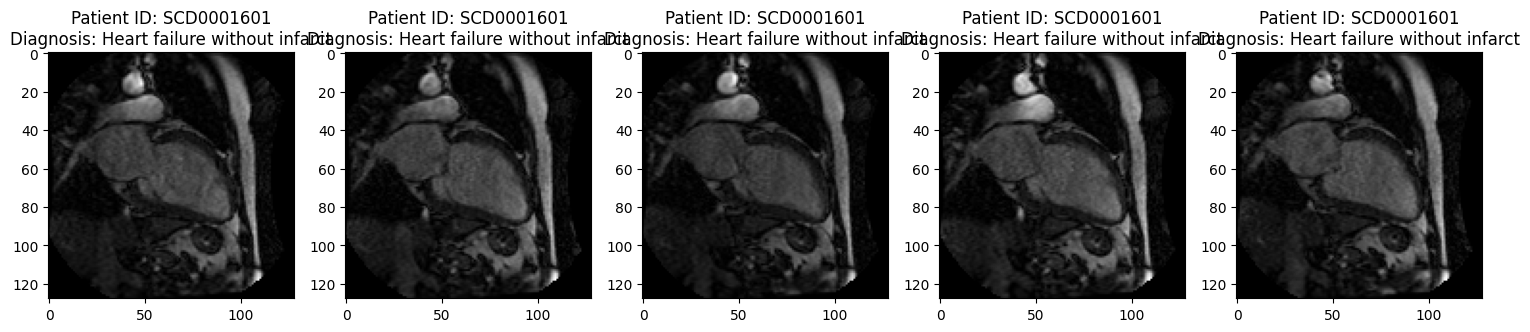

In [6]:
# Assuming dicom_data contains the processed DICOM data
num_entries_to_display = 5  # Number of entries to display
fig, axs = plt.subplots(1, num_entries_to_display, figsize=(15, 5))

for i in range(min(num_entries_to_display, len(dicom_data))):
    dicom_item = dicom_data[i]
    dicom_file = dicom_item[0]  # DICOM file object
    patient_id = dicom_item[1]  # Patient ID
    diagnosis = dicom_item[2]   # Diagnosis

    # Get the image data from the DICOM file
    image_data = dicom_file.pixel_array

    # Display the image and set the title
    axs[i].imshow(image_data, cmap='gray')
    axs[i].set_title(f"Patient ID: {patient_id}\nDiagnosis: {diagnosis}")

plt.tight_layout()
plt.show()

In [7]:
from random import sample
from skimage.transform import resize

# Define the target shape for resizing
target_shape = (256, 256)  # Change the dimensions as needed

# Convert dicom_data to numpy arrays
dicom_data_np = np.array(dicom_data)

# Randomly select 10000 objects from dicom_data
selected_indices = sample(range(len(dicom_data_np)), 7500)
selected_dicom_data = dicom_data_np[selected_indices]

pixel_arrays = []
patient_ids = []
diagnoses = []

for dicom_item in selected_dicom_data:
    dicom_file = dicom_item[0]  # DICOM file object
    patient_id = dicom_item[1]  # Patient ID
    diagnosis = dicom_item[2]   # Diagnosis

    # Get the image data from the DICOM file and resize it
    image_data = dicom_file.pixel_array
    resized_image = resize(image_data, target_shape, anti_aliasing=True)

    pixel_arrays.append(resized_image)

    # Append patient ID and diagnosis to respective lists
    patient_ids.append(patient_id)
    diagnoses.append(diagnosis)

pixel_arrays = np.array(pixel_arrays)
patient_ids = np.array(patient_ids)
diagnoses = np.array(diagnoses)


# After this loop, pixel_arrays has an indexed list of images corresponding to
# the keys in patient_ids and diagnoses. Each pixel_arrays entry is a 256x256
# image that can now be fed into a CNN

In [8]:
# split the training and testing data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode diagnoses as numbers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(diagnoses)

x_train_data, x_val_data = train_test_split(pixel_arrays, test_size=0.2, random_state=42)
y_train_data, y_val_data = train_test_split(y_encoded, test_size=0.2, random_state=42)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization


x_train_data = np.expand_dims(x_train_data, axis=-1)

# Assuming y_train_data is a numpy array of shape (num_samples,) containing integer labels
num_classes = len(np.unique(y_train_data))

# Define the CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=x_train_data.shape[1:]),  # Input shape excluding batch size
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                        

In [10]:
# Convert y_train_data from list to numpy array
y_train_data = np.array(y_train_data)

# Train the model
hist = cnn_model.fit(x_train_data, y_train_data,
                     epochs=10,
                     batch_size=32,
                     validation_data=(x_val_data, y_val_data))

# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(x_val_data, y_val_data)
test_acc = 100 * test_acc
print(f'Final test accuracy: {test_acc:.2f}%')

Epoch 1/10
188/188 [==============================] - 20s 70ms/step - loss: 0.9395 - accuracy: 0.6117 - val_loss: 3.8185 - val_accuracy: 0.2853
Epoch 2/10
188/188 [==============================] - 11s 56ms/step - loss: 0.2784 - accuracy: 0.9005 - val_loss: 2.8965 - val_accuracy: 0.3107
Epoch 3/10
188/188 [==============================] - 11s 56ms/step - loss: 0.1385 - accuracy: 0.9502 - val_loss: 0.4307 - val_accuracy: 0.8607
Epoch 4/10
188/188 [==============================] - 11s 56ms/step - loss: 0.0994 - accuracy: 0.9665 - val_loss: 0.7900 - val_accuracy: 0.6560
Epoch 5/10
188/188 [==============================] - 11s 56ms/step - loss: 0.0674 - accuracy: 0.9743 - val_loss: 2.9917 - val_accuracy: 0.5753
Epoch 6/10
188/188 [==============================] - 11s 56ms/step - loss: 0.0537 - accuracy: 0.9828 - val_loss: 9.8333 - val_accuracy: 0.3573
Epoch 7/10
188/188 [==============================] - 11s 56ms/step - loss: 0.0668 - accuracy: 0.9805 - val_loss: 0.4655 - val_accuracy:

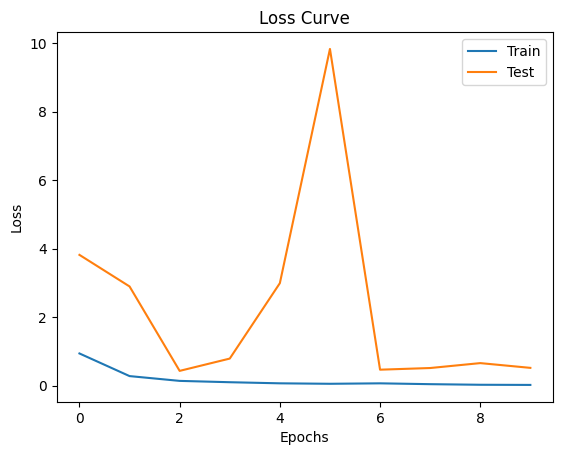

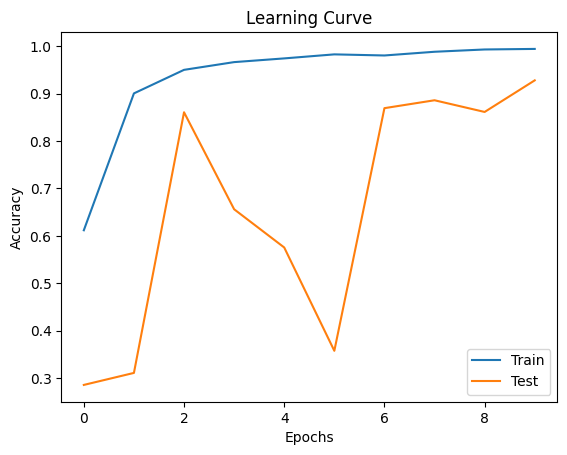

In [11]:
# plot the loss of the training and validation data sets
plt.title("Loss Curve")
plt.plot(np.arange(10), hist.history.get('loss'), label="Train")
plt.plot(np.arange(10), hist.history.get('val_loss'), label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

# plot the training and validation accuracies
plt.title("Learning Curve")
plt.plot(np.arange(10),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(10),hist.history.get('val_accuracy'), label="Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

We observe with the initial trial above with a simple CNN that the diagnostic accuracy is not great. Below, we'll incorporate physical layers.

In [12]:
# Encode diagnoses as numbers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(diagnoses)

x_train_data, x_val_data = train_test_split(pixel_arrays, test_size=0.2, random_state=42)
y_train_data, y_val_data = train_test_split(y_encoded, test_size=0.2, random_state=42)

from tensorflow.keras.utils import to_categorical

num_classes = len(np.unique(y_encoded))

y_train_data = to_categorical(y_train_data, num_classes=num_classes)
y_val_data = to_categorical(y_val_data, num_classes=num_classes)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 k_space_masking_layer (KSp  (None, 256, 256, 1)       16384     
 aceMaskingLayer)                                                
                                                                 
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 batch_normalization_1 (Bat  (None, 254, 254, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                      

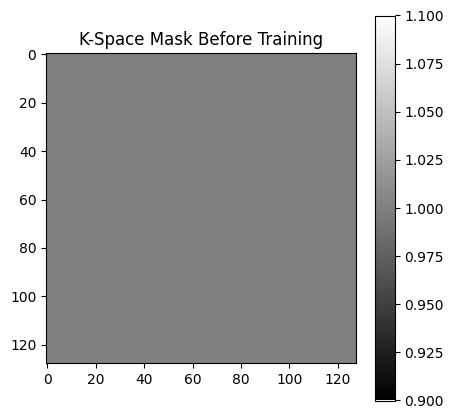

In [14]:
from tensorflow.keras.layers import Layer

class ContrastAdjustmentLayer(Layer):
    def __init__(self, **kwargs):
        super(ContrastAdjustmentLayer, self).__init__(**kwargs)
        self.contrast_factor = self.add_weight(shape=(), initializer='ones', trainable=True)

    def call(self, inputs):
        return inputs * self.contrast_factor

class RandomTranslationLayer(Layer):
    def __init__(self, max_shift=10, **kwargs):
        super(RandomTranslationLayer, self).__init__(**kwargs)
        self.max_shift = max_shift

    def call(self, inputs):
        # Generate random shifts
        shift_x = tf.random.uniform(shape=[], minval=-self.max_shift, maxval=self.max_shift, dtype=tf.int32)
        shift_y = tf.random.uniform(shape=[], minval=-self.max_shift, maxval=self.max_shift, dtype=tf.int32)

        # Pad the images to handle translation
        padded_inputs = tf.pad(inputs, [[0, 0], [self.max_shift, self.max_shift], [self.max_shift, self.max_shift], [0, 0]], mode='CONSTANT')

        # Apply translation using cropping
        translated_tensor = tf.image.crop_to_bounding_box(padded_inputs, self.max_shift + shift_x, self.max_shift + shift_y, inputs.shape[1], inputs.shape[2])

        return translated_tensor

class KSpaceMaskingLayer(Layer):
    def __init__(self, mask_size, **kwargs):
        super(KSpaceMaskingLayer, self).__init__(**kwargs)
        self.mask_size = mask_size
        self.mask = self.add_weight(shape=(mask_size, mask_size, 1, 1), initializer=tf.initializers.ones(), trainable=True, dtype=tf.complex64)

    def call(self, inputs):
        # Convert input to complex64
        inputs = tf.cast(inputs, tf.complex64)

        # Take the 2D FFT of the input images
        fft_images = tf.signal.fft2d(inputs)

        # Get the shape of fft_images
        batch_size, height, width, channels = tf.unstack(tf.shape(fft_images))

        # Reshape the mask to match the spatial dimensions of fft_images
        mask = tf.reshape(self.mask, [1, self.mask_size, self.mask_size, 1])
        mask = tf.tile(mask, [batch_size, height // self.mask_size, width // self.mask_size, channels])

        # Apply the trainable mask to the k-space data
        fft_images = fft_images * mask

        # Take the inverse 2D FFT to transform back to the image domain
        masked_images = tf.math.real(tf.signal.ifft2d(fft_images))

        return masked_images

contrast_layer = ContrastAdjustmentLayer()
translation_layer = RandomTranslationLayer()
kspacemask_layer = KSpaceMaskingLayer(mask_size=128)

# Define the CNN model
cnn_model = Sequential([
    kspacemask_layer,
    #contrast_layer,  # Add contrast adjustment layer
    #noise_layer,  # Add Gaussian noise simulation
    #translation_layer,  # Add random translation simulation
    Conv2D(32, (3, 3), activation='relu', input_shape=x_train_data.shape[1:]),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    #downsampling_layer,
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    #downsampling_layer,
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

cnn_model.build(input_shape=(None, 256,256,1))

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Now you can call model.summary()
cnn_model.summary()

mask_before_training = cnn_model.weights[0].numpy()

# Plot the mask before training
plt.figure(figsize=(5, 5))
plt.imshow(np.abs(mask_before_training.squeeze()), cmap='gray')
plt.colorbar()
plt.title('K-Space Mask Before Training')
plt.show()

In [15]:
# Train the model
hist = cnn_model.fit(x_train_data, y_train_data,
                     epochs=10,
                     batch_size=32,
                     validation_data=(x_val_data, y_val_data))

# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(x_val_data, y_val_data)
test_acc = 100 * test_acc
print(f'Final test accuracy: {test_acc:.2f}%')

Epoch 1/10
188/188 [==============================] - 15s 65ms/step - loss: 0.9744 - accuracy: 0.5858 - val_loss: 1.9729 - val_accuracy: 0.2900
Epoch 2/10
188/188 [==============================] - 11s 59ms/step - loss: 0.3346 - accuracy: 0.8775 - val_loss: 2.7913 - val_accuracy: 0.3040
Epoch 3/10
188/188 [==============================] - 11s 60ms/step - loss: 0.1414 - accuracy: 0.9488 - val_loss: 0.6862 - val_accuracy: 0.7687
Epoch 4/10
188/188 [==============================] - 11s 59ms/step - loss: 0.0915 - accuracy: 0.9672 - val_loss: 1.2505 - val_accuracy: 0.6287
Epoch 5/10
188/188 [==============================] - 11s 59ms/step - loss: 0.0724 - accuracy: 0.9747 - val_loss: 1.1138 - val_accuracy: 0.7627
Epoch 6/10
188/188 [==============================] - 11s 59ms/step - loss: 0.0716 - accuracy: 0.9768 - val_loss: 0.4594 - val_accuracy: 0.8767
Epoch 7/10
188/188 [==============================] - 11s 59ms/step - loss: 0.0269 - accuracy: 0.9920 - val_loss: 0.4590 - val_accuracy:

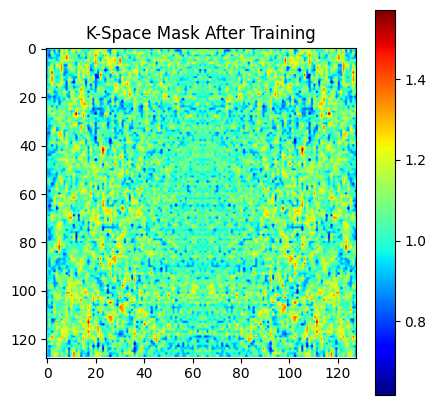

In [16]:
mask_after_training = cnn_model.weights[0].numpy()

# Plot the mask after training
plt.figure(figsize=(5, 5))
plt.imshow(np.abs(mask_after_training.squeeze()), cmap='jet')
plt.colorbar()
plt.title('K-Space Mask After Training')
plt.show()

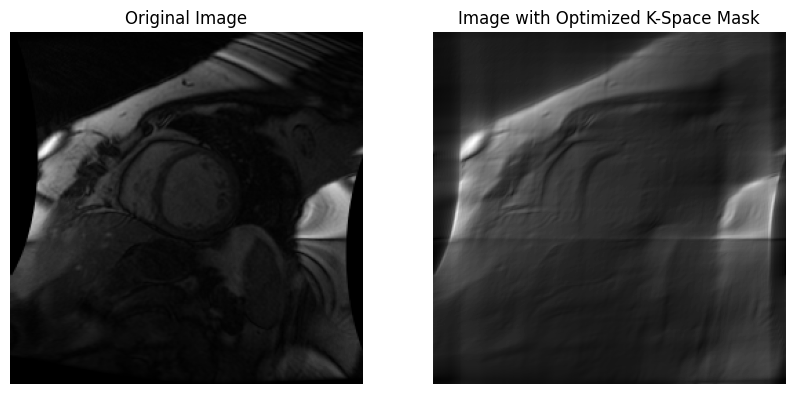

In [18]:
# Display effects of optimized mask

test_image = pixel_arrays[114]

# Visualize the first frame
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Take the 2D FFT of the image
fft_image = np.fft.fft2(test_image)

# Define the k-space mask
mask_size = 128
mask = np.ones((mask_size, mask_size), dtype=np.complex128)

# Pad the mask to match the size of the FFT image
padded_mask = np.pad(mask, ((0, fft_image.shape[0] - mask.shape[0]),
                             (0, fft_image.shape[1] - mask.shape[1])),
                     mode='constant')

# Apply the k-space mask
fft_image_masked = fft_image * padded_mask

# Take the inverse 2D FFT to transform back to the image domain
image_masked = np.abs(np.fft.ifft2(fft_image_masked))

# Visualize the masked image
plt.subplot(1, 2, 2)
plt.imshow(image_masked, cmap='gray')
plt.title('Image with Optimized K-Space Mask')
plt.axis('off')
plt.show()

# images 2249
# image 111

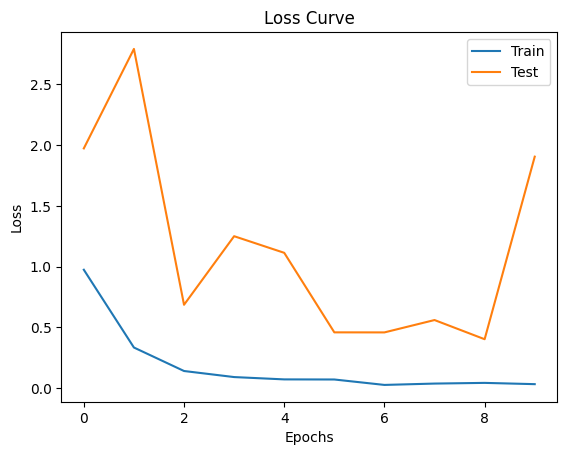

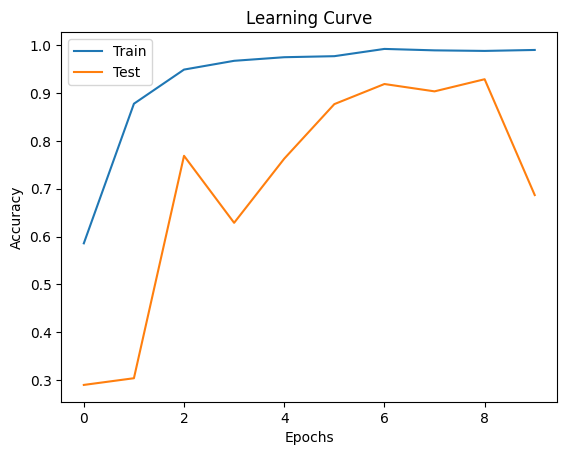

In [19]:
# plot the loss of the training and validation data sets
plt.title("Loss Curve")
plt.plot(np.arange(10), hist.history.get('loss'), label="Train")
plt.plot(np.arange(10), hist.history.get('val_loss'), label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

# plot the training and validation accuracies
plt.title("Learning Curve")
plt.plot(np.arange(10),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(10),hist.history.get('val_accuracy'), label="Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

In [20]:
# Encode diagnoses as numbers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(diagnoses)

x_train_data, x_val_data = train_test_split(pixel_arrays, test_size=0.2, random_state=42)
y_train_data, y_val_data = train_test_split(y_encoded, test_size=0.2, random_state=42)

from tensorflow.keras.utils import to_categorical

num_classes = len(np.unique(y_encoded))

y_train_data = to_categorical(y_train_data, num_classes=num_classes)
y_val_data = to_categorical(y_val_data, num_classes=num_classes)

In [22]:
class RowConstantKSpaceMaskingLayer(Layer):
    def __init__(self, mask_size, **kwargs):
        super(RowConstantKSpaceMaskingLayer, self).__init__(**kwargs)
        self.mask_size = mask_size

    def build(self, input_shape):
        # Create a row-repeated mask
        self.row_mask = self.add_weight(
            shape=(self.mask_size, 1, 1, 1),
            initializer=tf.initializers.ones(),
            trainable=True,
            dtype=tf.complex64,
        )

    def call(self, inputs):
        # Convert input to complex64
        inputs = tf.cast(inputs, tf.complex64)

        # Take the 2D FFT of the input images
        fft_images = tf.signal.fft2d(inputs)

        # Get the shape of fft_images
        batch_size, height, width, channels = tf.unstack(tf.shape(fft_images))

        # Reshape the row mask to match the spatial dimensions of fft_images
        mask = tf.tile(self.row_mask, [1, self.mask_size, 1, 1])
        mask = tf.reshape(mask, [1, self.mask_size, self.mask_size, 1])
        mask = tf.tile(mask, [batch_size, height // self.mask_size, width // self.mask_size, channels])

        # Apply the trainable mask to the k-space data
        fft_images = fft_images * mask

        # Take the inverse 2D FFT to transform back to the image domain
        masked_images = tf.math.real(tf.signal.ifft2d(fft_images))

        return masked_images

    def get_initial_mask(self):
        initial_mask = tf.ones(shape=(self.mask_size, self.mask_size, 1, 1), dtype=tf.complex64)
        return initial_mask

    def get_final_mask(self):
        final_row_mask = self.row_mask.numpy()
        final_mask = np.tile(final_row_mask, (1, self.mask_size, 1, 1))
        return final_mask

contrast_layer = ContrastAdjustmentLayer()
translation_layer = RandomTranslationLayer()
rowmask_layer = RowConstantKSpaceMaskingLayer(mask_size=128)

# Define the CNN model
cnn_model = Sequential([
    rowmask_layer,
    #contrast_layer,  # Add contrast adjustment layer
    #noise_layer,  # Add Gaussian noise simulation
    #translation_layer,  # Add random translation simulation
    Conv2D(32, (3, 3), activation='relu', input_shape=x_train_data.shape[1:]),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    #downsampling_layer,
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    #downsampling_layer,
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

cnn_model.build(input_shape=(None, 256,256,1))

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Now you can call model.summary()
cnn_model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 row_constant_k_space_maski  (None, 256, 256, 1)       128       
 ng_layer (RowConstantKSpac                                      
 eMaskingLayer)                                                  
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 batch_normalization_2 (Bat  (None, 254, 254, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)     

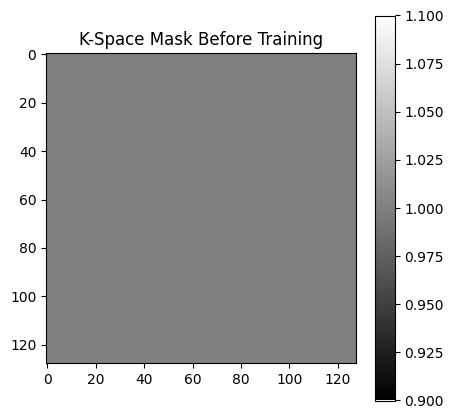

In [23]:
row_constant_kspacemask_layer = RowConstantKSpaceMaskingLayer(mask_size=128)

# Get the initial mask
initial_mask = row_constant_kspacemask_layer.get_initial_mask()


plt.figure(figsize=(5, 5))
plt.imshow(np.abs(initial_mask.numpy().squeeze()), cmap='gray')
plt.colorbar()
plt.title('K-Space Mask Before Training')
plt.show()

In [24]:
# Train the model
hist = cnn_model.fit(x_train_data, y_train_data,
                     epochs=10,
                     batch_size=32,
                     validation_data=(x_val_data, y_val_data))

# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(x_val_data, y_val_data)
test_acc = 100 * test_acc
print(f'Final test accuracy: {test_acc:.2f}%')

Epoch 1/10
188/188 [==============================] - 14s 65ms/step - loss: 1.0084 - accuracy: 0.5740 - val_loss: 1.2877 - val_accuracy: 0.3927
Epoch 2/10
188/188 [==============================] - 11s 59ms/step - loss: 0.3061 - accuracy: 0.8905 - val_loss: 1.5992 - val_accuracy: 0.3267
Epoch 3/10
188/188 [==============================] - 11s 59ms/step - loss: 0.1300 - accuracy: 0.9533 - val_loss: 0.7627 - val_accuracy: 0.7213
Epoch 4/10
188/188 [==============================] - 11s 59ms/step - loss: 0.0939 - accuracy: 0.9660 - val_loss: 0.3320 - val_accuracy: 0.9080
Epoch 5/10
188/188 [==============================] - 11s 59ms/step - loss: 0.0634 - accuracy: 0.9797 - val_loss: 0.3880 - val_accuracy: 0.9160
Epoch 6/10
188/188 [==============================] - 11s 59ms/step - loss: 0.0651 - accuracy: 0.9807 - val_loss: 0.4676 - val_accuracy: 0.9087
Epoch 7/10
188/188 [==============================] - 11s 59ms/step - loss: 0.0468 - accuracy: 0.9880 - val_loss: 0.4412 - val_accuracy:

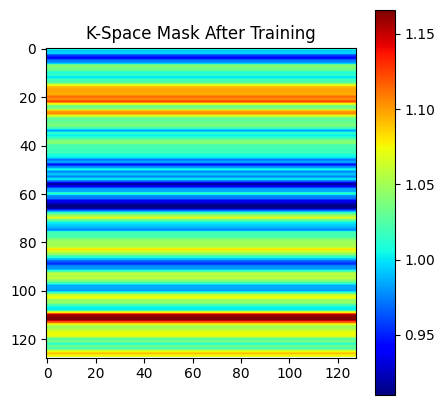

In [25]:
def expand_final_mask_weights(mask_weights, mask_size):
    expanded_mask = np.zeros((mask_size, mask_size), dtype=np.complex64)
    for i in range(mask_size):
        expanded_mask[i, :] = mask_weights[i]
    return expanded_mask

final_mask_weights = cnn_model.weights[0].numpy()

# Expand the final mask weights to a 128x128 panel
expanded_final_mask = expand_final_mask_weights(final_mask_weights, 128)


plt.figure(figsize=(5, 5))
plt.imshow(np.abs(expanded_final_mask.squeeze()), cmap='jet')
plt.colorbar()
plt.title('K-Space Mask After Training')
plt.show()

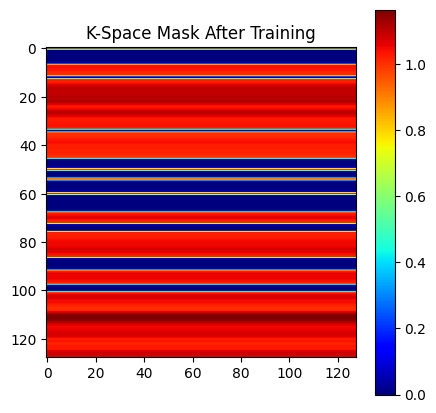

Number of rows changed to zeros: 38


In [26]:
def expand_final_mask_weights(mask_weights, mask_size):
    expanded_mask = np.zeros((mask_size, mask_size), dtype=np.complex64)
    num_changed_rows = 0  # Initialize the counter for changed rows
    for i in range(mask_size):
        expanded_mask[i, :] = mask_weights[i]

    # Set rows with values less than 1 to zero and count the number of changed rows
    changed_rows = np.any(expanded_mask < 1, axis=1)
    expanded_mask[changed_rows, :] = 0
    num_changed_rows = np.sum(changed_rows)

    return expanded_mask, num_changed_rows

# Example usage
expanded_final_mask, num_changed_rows = expand_final_mask_weights(final_mask_weights, 128)

# Visualize the expanded mask
plt.figure(figsize=(5, 5))
plt.imshow(np.abs(expanded_final_mask.squeeze()), cmap='jet')
plt.colorbar()
plt.title('K-Space Mask After Training')
plt.show()

print("Number of rows changed to zeros:", num_changed_rows)

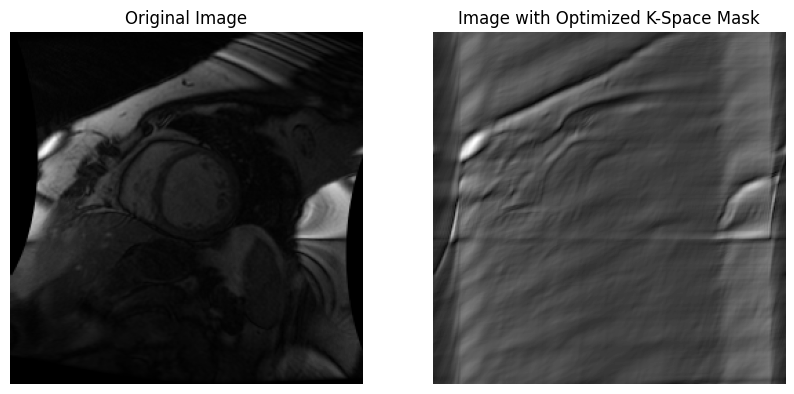

In [27]:
test_image = pixel_arrays[114]

# Take the 2D FFT of the test image
fft_test_image = np.fft.fft2(test_image)

# Pad the expanded_final_mask to match the size of the FFT image
padded_mask = np.pad(expanded_final_mask, ((0, fft_test_image.shape[0] - expanded_final_mask.shape[0]),
                                           (0, fft_test_image.shape[1] - expanded_final_mask.shape[1])),
                     mode='constant')

# Apply the expanded_final_mask to the test image
fft_test_image_masked = fft_test_image * padded_mask

# Take the inverse 2D FFT to transform back to the image domain
test_image_masked = np.abs(np.fft.ifft2(fft_test_image_masked))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(test_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(test_image_masked, cmap='gray')
plt.title('Image with Optimized K-Space Mask')
plt.axis('off')

plt.show()

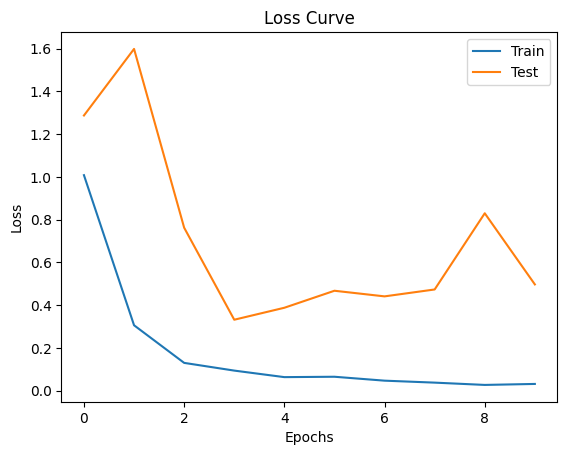

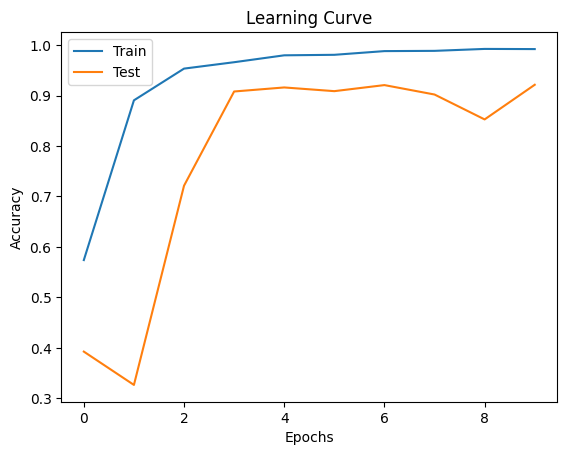

In [28]:
# plot the loss of the training and validation data sets
plt.title("Loss Curve")
plt.plot(np.arange(10), hist.history.get('loss'), label="Train")
plt.plot(np.arange(10), hist.history.get('val_loss'), label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

# plot the training and validation accuracies
plt.title("Learning Curve")
plt.plot(np.arange(10),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(10),hist.history.get('val_accuracy'), label="Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

Below, we now use the masked images to evaluate diagnostic accuracy.

In [29]:
### Now, using the original, simple CNN with the modified images

masked_data = np.fft.fft2(pixel_arrays)

# Pad the expanded_final_mask to match the size of the FFT image
padded_mask = np.pad(expanded_final_mask, ((0, fft_test_image.shape[0] - expanded_final_mask.shape[0]),
                                           (0, fft_test_image.shape[1] - expanded_final_mask.shape[1])),
                     mode='constant')

# Apply the expanded_final_mask to the test image
fft_test_image_masked = masked_data * padded_mask

# Take the inverse 2D FFT to transform back to the image domain
image_data_masked = np.abs(np.fft.ifft2(fft_test_image_masked))


In [33]:
# Encode diagnoses as numbers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(diagnoses)

x_train_data, x_val_data = train_test_split(image_data_masked, test_size=0.2, random_state=42)
y_train_data, y_val_data = train_test_split(y_encoded, test_size=0.2, random_state=42)

In [34]:
x_train_data = np.expand_dims(x_train_data, axis=-1)

# Assuming y_train_data is a numpy array of shape (num_samples,) containing integer labels
num_classes = len(np.unique(y_train_data))


# Define the CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=x_train_data.shape[1:]),  # Input shape excluding batch size
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()

# Convert y_train_data from list to numpy array
y_train_data = np.array(y_train_data)

# Train the model
hist = cnn_model.fit(x_train_data, y_train_data,
                     epochs=10,
                     batch_size=32,
                     validation_data=(x_val_data, y_val_data))

# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(x_val_data, y_val_data)
test_acc = 100 * test_acc
print(f'Final test accuracy: {test_acc:.2f}%')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 batch_normalization_4 (Bat  (None, 254, 254, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                      

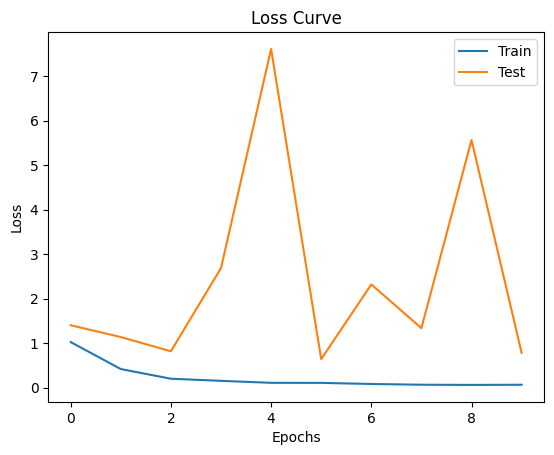

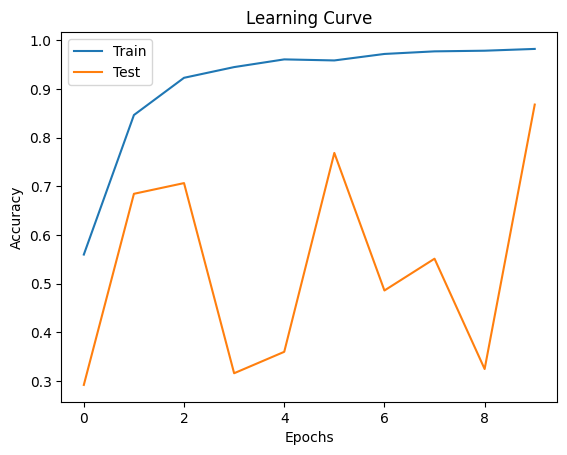

In [35]:
# plot the loss of the training and validation data sets
plt.title("Loss Curve")
plt.plot(np.arange(10), hist.history.get('loss'), label="Train")
plt.plot(np.arange(10), hist.history.get('val_loss'), label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

# plot the training and validation accuracies
plt.title("Learning Curve")
plt.plot(np.arange(10),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(10),hist.history.get('val_accuracy'), label="Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()